# Experiment 3 - look at accuracies as a function of number of practiced tasks trained

In [586]:
import numpy as np
import torch
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from model import analysis
from model import task
from importlib import reload
import tools
import pandas as pd
analysis = reload(analysis)
tools = reload(tools)
import statsmodels.sandbox.stats.multicomp as mc

In [587]:
datadir = '../../data/results/experiment5/'
taskdir = '../../data/results/model/'

# Load tasks and task labels, and compute PS for each network

#### Load task data and labels

In [588]:
task = reload(task)
taskset = task.createRulePermutations()
inputcode2d = np.zeros((len(taskset),27))
for i in range(len(taskset)):
    inputcode2d[i,:11] = taskset.Code[i]
taskinfo = taskset
inputcode2d = torch.from_numpy(inputcode2d).float()

# inputcode, outputcode, taskinfo = task.create_all_trials(taskset,output_taskinfo=True)
# inputcode = torch.from_numpy(inputcode.T).float()
# inputcode2d = inputcode.reshape(inputcode.shape[0]*inputcode.shape[1],inputcode.shape[2])

#### Forward pass to get hidden activations of 

In [589]:
tools = reload(tools)
nsimulations = 20

ps_logic_pretraining = np.zeros((4,4,nsimulations))
ps_sensory_pretraining = np.zeros((4,4,nsimulations))
ps_motor_pretraining = np.zeros((4,4,nsimulations))
#
ps_logic_nopretraining = np.zeros((4,4,nsimulations))
ps_sensory_nopretraining = np.zeros((4,4,nsimulations))
ps_motor_nopretraining = np.zeros((4,4,nsimulations))

for i in range(nsimulations):
    network_pretraining = torch.load(datadir + 'expt5_adam_200epochs_2layers_pretraining_practice' + str(i) + '_4practiceTasks.pt',
                                     map_location=torch.device('cpu'))
    network_nopretraining = torch.load(datadir + 'expt5_adam_200epochs_2layers_practice' + str(i) + '_4practiceTasks.pt',
                                     map_location=torch.device('cpu'))

    outputs_pretraining, hidden_pretraining = network_pretraining.forward(inputcode2d,noise=False,dropout=False)
    outputs_nopretraining, hidden_nopretraining = network_nopretraining.forward(inputcode2d,noise=False,dropout=False)

    pretrained_activations = hidden_pretraining.detach().numpy()
    nopretrain_activations = hidden_nopretraining.detach().numpy()
    
    #### Compute PS for LOGIC rules
    ps_pretrained, classes_logic = tools.parallelismScore(pretrained_activations,
                                                          taskinfo.Logic.values,
                                                          taskinfo.Sensory.values,
                                                          taskinfo.Motor.values)
    ps_logic_pretraining[:,:,i] = ps_pretrained
    #
    ps_nopretrained, classes_logic = tools.parallelismScore(nopretrain_activations,
                                                            taskinfo.Logic.values,
                                                            taskinfo.Sensory.values,
                                                            taskinfo.Motor.values)
    ps_logic_nopretraining[:,:,i] = ps_nopretrained
    
    #### Compute PS for SENSORY rules
    ps_pretrained, classes_sensory = tools.parallelismScore(pretrained_activations,
                                                            taskinfo.Sensory.values,
                                                            taskinfo.Logic.values,
                                                            taskinfo.Motor.values)
    ps_sensory_pretraining[:,:,i] = ps_pretrained
    #
    ps_nopretrained, classes_sensory = tools.parallelismScore(nopretrain_activations,
                                                              taskinfo.Sensory.values,
                                                              taskinfo.Logic.values,
                                                              taskinfo.Motor.values)
    ps_sensory_nopretraining[:,:,i] = ps_nopretrained
    
    #### Compute PS for MOTOR rules
    ps_pretrained, classes_motor = tools.parallelismScore(pretrained_activations,
                                                          taskinfo.Motor.values,
                                                          taskinfo.Logic.values,
                                                          taskinfo.Sensory.values)
    ps_motor_pretraining[:,:,i] = ps_pretrained
    #
    ps_nopretrained, classes_motor = tools.parallelismScore(nopretrain_activations,
                                                            taskinfo.Motor.values,
                                                            taskinfo.Logic.values,
                                                            taskinfo.Sensory.values)
    ps_motor_nopretraining[:,:,i] = ps_nopretrained
    


#### Create null distribution (shuffled representations)

In [590]:
tools = reload(tools)
nsimulations = 20
npermutations = 100

ps_logic_pretraining_perm = np.zeros((4,4,nsimulations,npermutations))
ps_sensory_pretraining_perm = np.zeros((4,4,nsimulations,npermutations))
ps_motor_pretraining_perm = np.zeros((4,4,nsimulations,npermutations))
#
ps_logic_nopretraining_perm = np.zeros((4,4,nsimulations,npermutations))
ps_sensory_nopretraining_perm = np.zeros((4,4,nsimulations,npermutations))
ps_motor_nopretraining_perm = np.zeros((4,4,nsimulations,npermutations))

for i in range(nsimulations):
    network_pretraining = torch.load(datadir + 'expt5_adam_200epochs_2layers_pretraining_practice' + str(i) + '_4practiceTasks.pt',
                                     map_location=torch.device('cpu'))
    network_nopretraining = torch.load(datadir + 'expt5_adam_200epochs_2layers_practice' + str(i) + '_4practiceTasks.pt',
                                     map_location=torch.device('cpu'))

    outputs_pretraining, hidden_pretraining = network_pretraining.forward(inputcode2d,noise=False,dropout=False)
    outputs_nopretraining, hidden_nopretraining = network_nopretraining.forward(inputcode2d,noise=False,dropout=False)

    pretrained_activations = hidden_pretraining.detach().numpy()
    nopretrain_activations = hidden_nopretraining.detach().numpy()
    
    #### Compute PS for LOGIC rules
    for j in range(npermutations):
        #
        ps_pretrained, classes_logic = tools.parallelismScore(pretrained_activations,
                                                              taskinfo.Logic.values,
                                                              taskinfo.Sensory.values,
                                                              taskinfo.Motor.values,
                                                              shuffle=True)
        ps_logic_pretraining_perm[:,:,i,j] = ps_pretrained
        #
        ps_nopretrained, classes_logic = tools.parallelismScore(nopretrain_activations,
                                                                taskinfo.Logic.values,
                                                                taskinfo.Sensory.values,
                                                                taskinfo.Motor.values,
                                                                shuffle=True)
        ps_logic_nopretraining_perm[:,:,i,j] = ps_nopretrained
    
    
    #### Compute PS for SENSORY rules
    for j in range(npermutations):
        #
        ps_pretrained, classes_sensory = tools.parallelismScore(pretrained_activations,
                                                                taskinfo.Sensory.values,
                                                                taskinfo.Logic.values,
                                                                taskinfo.Motor.values,
                                                                shuffle=True)
        ps_sensory_pretraining_perm[:,:,i,j] = ps_pretrained
        #
        ps_nopretrained, classes_sensory = tools.parallelismScore(nopretrain_activations,
                                                                  taskinfo.Sensory.values,
                                                                  taskinfo.Logic.values,
                                                                  taskinfo.Motor.values,
                                                                  shuffle=True)
        ps_sensory_nopretraining_perm[:,:,i,j] = ps_nopretrained
    
    #### Compute PS for MOTOR rules
    for j in range(npermutations):
        ps_pretrained, classes_motor = tools.parallelismScore(pretrained_activations,
                                                              taskinfo.Motor.values,
                                                              taskinfo.Logic.values,
                                                              taskinfo.Sensory.values,
                                                              shuffle=True)
        ps_motor_pretraining_perm[:,:,i,j] = ps_pretrained
        #
        ps_nopretrained, classes_motor = tools.parallelismScore(nopretrain_activations,
                                                                taskinfo.Motor.values,
                                                                taskinfo.Logic.values,
                                                                taskinfo.Sensory.values,
                                                                shuffle=True)
        ps_motor_nopretraining_perm[:,:,i,j] = ps_nopretrained

# Compute the averaged PS for each rule domain

In [591]:
df = {}
df['Rule'] = []
df['Simulation'] = []
df['ParallelismScore'] = []
df['NetworkType'] = []
triu_ind = np.triu_indices(4,k=1)

for i in range(nsimulations):
    df['Rule'].append('Logic')
    df['ParallelismScore'].append(np.mean(ps_logic_pretraining[:,:,i][triu_ind]))
    df['Simulation'].append(i)
    df['NetworkType'].append('Pretraining')
    #
    df['Rule'].append('Logic')
    df['ParallelismScore'].append(np.mean(ps_logic_nopretraining[:,:,i][triu_ind]))
    df['Simulation'].append(i)
    df['NetworkType'].append('NoPretraining')
    #
    #
    df['Rule'].append('Sensory')
    df['ParallelismScore'].append(np.mean(ps_sensory_pretraining[:,:,i][triu_ind]))
    df['Simulation'].append(i)
    df['NetworkType'].append('Pretraining')
    #
    df['Rule'].append('Sensory')
    df['ParallelismScore'].append(np.mean(ps_sensory_nopretraining[:,:,i][triu_ind]))
    df['Simulation'].append(i)
    df['NetworkType'].append('NoPretraining')
    #
    #
    df['Rule'].append('Motor')
    df['ParallelismScore'].append(np.mean(ps_motor_pretraining[:,:,i][triu_ind]))
    df['Simulation'].append(i)
    df['NetworkType'].append('Pretraining')
    #
    df['Rule'].append('Motor')
    df['ParallelismScore'].append(np.mean(ps_motor_nopretraining[:,:,i][triu_ind]))
    df['Simulation'].append(i)
    df['NetworkType'].append('NoPretraining')

df = pd.DataFrame(df)


In [592]:
df_null = {}
df_null['Rule'] = []
df_null['Simulation'] = []
df_null['ParallelismScore'] = []
df_null['NetworkType'] = []
for i in range(nsimulations):
    df_null['Rule'].extend(np.repeat('Logic',npermutations))
    for j in range(npermutations):
        df_null['ParallelismScore'].append(np.mean(ps_logic_pretraining_perm[:,:,i,j][triu_ind]))
    df_null['Simulation'].extend(np.repeat(i,npermutations))
    df_null['NetworkType'].extend(np.repeat('Pretraining',npermutations))
    #
    df_null['Rule'].extend(np.repeat('Logic',npermutations))
    for j in range(npermutations):
        df_null['ParallelismScore'].append(np.mean(ps_logic_nopretraining_perm[:,:,i,j][triu_ind]))
    df_null['Simulation'].extend(np.repeat(i,npermutations))
    df_null['NetworkType'].extend(np.repeat('NoPretraining',npermutations))
    #
    #
    df_null['Rule'].extend(np.repeat('Sensory',npermutations))
    for j in range(npermutations):
        df_null['ParallelismScore'].append(np.mean(ps_sensory_pretraining_perm[:,:,i,j][triu_ind]))
    df_null['Simulation'].extend(np.repeat(i,npermutations))
    df_null['NetworkType'].extend(np.repeat('Pretraining',npermutations))
    #
    df_null['Rule'].extend(np.repeat('Sensory',npermutations))
    for j in range(npermutations):
        df_null['ParallelismScore'].append(np.mean(ps_sensory_nopretraining_perm[:,:,i,j][triu_ind]))
    df_null['Simulation'].extend(np.repeat(i,npermutations))
    df_null['NetworkType'].extend(np.repeat('NoPretraining',npermutations))
    #
    #
    df_null['Rule'].extend(np.repeat('Motor',npermutations))
    for j in range(npermutations):
        df_null['ParallelismScore'].append(np.mean(ps_motor_pretraining_perm[:,:,i,j][triu_ind]))
    df_null['Simulation'].extend(np.repeat(i,npermutations))
    df_null['NetworkType'].extend(np.repeat('Pretraining',npermutations))
    #
    df_null['Rule'].extend(np.repeat('Motor',npermutations))
    for j in range(npermutations):
        df_null['ParallelismScore'].append(np.mean(ps_motor_nopretraining_perm[:,:,i,j][triu_ind]))
    df_null['Simulation'].extend(np.repeat(i,npermutations))
    df_null['NetworkType'].extend(np.repeat('NoPretraining',npermutations))


df_null = pd.DataFrame(df_null)


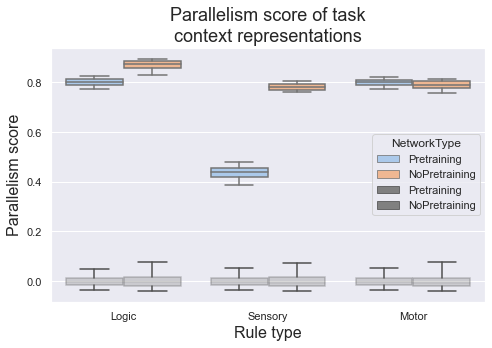

In [593]:
#### Plot
plt.figure(figsize=(7,5))
sns.set(font_scale=1)
sns.boxplot(x="Rule", y="ParallelismScore", hue='NetworkType', data=df,
            medianprops={'linestyle':'-'},sym='',whis=[2.5,97.5],palette="pastel")
sns.boxplot(x="Rule",y="ParallelismScore",hue="NetworkType",data=df_null,
            medianprops={'linestyle':'-','alpha':0.1},sym='',whis=[2.5,97.5],palette=['grey','grey'], boxprops=dict(alpha=.3))
plt.title("Parallelism score of task\ncontext representations",fontsize=18)
plt.xlabel('Rule type',fontsize=16)
plt.ylabel('Parallelism score',fontsize=16)
plt.tight_layout()

# Now compute PS for logic rules

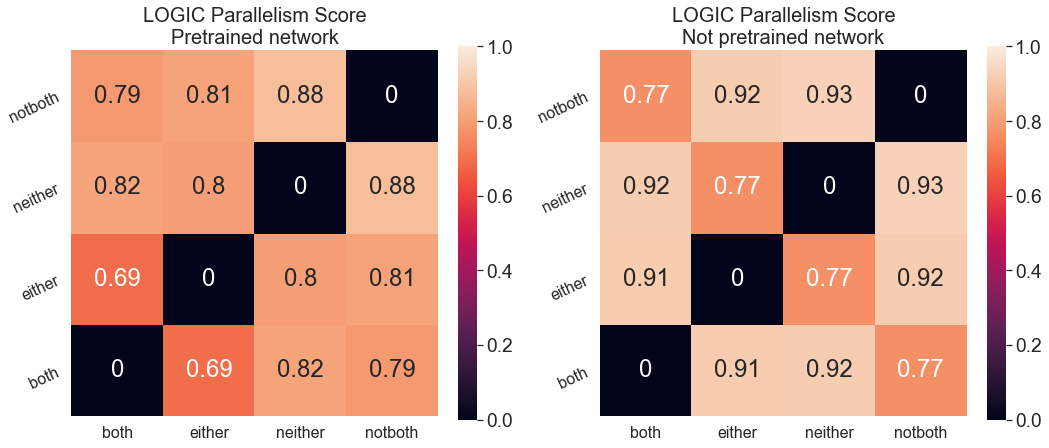

In [594]:
tools = reload(tools)

plt.figure(figsize=(15,7))
sns.set(font_scale=1.75)
plt.subplot(121)
mat = np.mean(ps_logic_pretraining,axis=2)
ax = sns.heatmap(mat,vmin=0,vmax=1,square=True,cbar=True,cbar_kws={'fraction':0.046},
                 annot=True,annot_kws={"size": 24})
ax.invert_yaxis()
plt.xticks(np.arange(0.5,len(classes_logic)+0.5),classes_logic,fontsize=16)
plt.yticks(np.arange(0.5,len(classes_logic)+0.5),classes_logic,fontsize=16,rotation=25)
plt.title("LOGIC Parallelism Score\nPretrained network",fontsize=20)

plt.subplot(122)
mat = np.mean(ps_logic_nopretraining,axis=2)
ax = sns.heatmap(mat,vmin=0,vmax=1,square=True,cbar=True,cbar_kws={'fraction':0.046},
                 annot=True,annot_kws={"size": 24})
ax.invert_yaxis()
plt.xticks(np.arange(0.5,len(classes_logic)+0.5),classes_logic,fontsize=16)
plt.yticks(np.arange(0.5,len(classes_logic)+0.5),classes_logic,fontsize=16,rotation=25)
plt.title("LOGIC Parallelism Score\nNot pretrained network",fontsize=20)
plt.tight_layout()


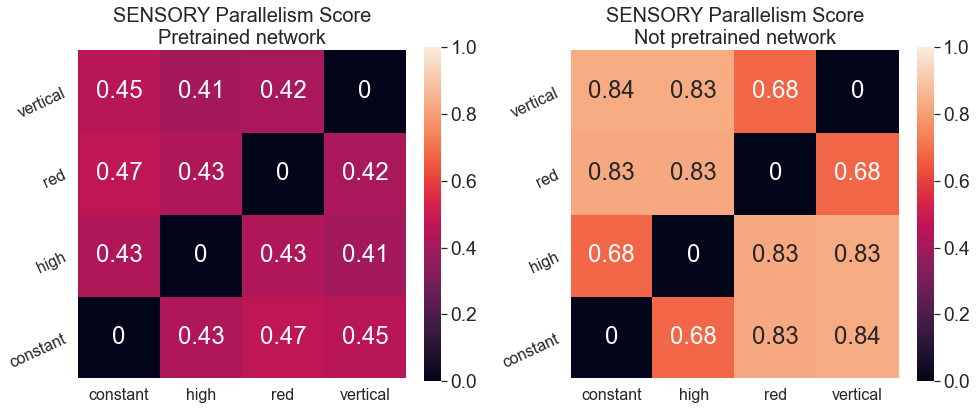

In [595]:
tools = reload(tools)

plt.figure(figsize=(14,7))
sns.set(font_scale=1.75)
plt.subplot(121)
mat = np.mean(ps_sensory_pretraining,axis=2)
ax = sns.heatmap(mat,vmin=0,vmax=1,square=True,cbar=True,cbar_kws={'fraction':0.046},
                 annot=True,annot_kws={"size": 24})
ax.invert_yaxis()
plt.xticks(np.arange(0.5,len(classes_sensory)+0.5),classes_sensory,fontsize=16)
plt.yticks(np.arange(0.5,len(classes_sensory)+0.5),classes_sensory,fontsize=16,rotation=25)
plt.title("SENSORY Parallelism Score\nPretrained network",fontsize=20)

plt.subplot(122)
mat = np.mean(ps_sensory_nopretraining,axis=2)
ax = sns.heatmap(mat,vmin=0,vmax=1,square=True,cbar=True,cbar_kws={'fraction':0.046},
                 annot=True,annot_kws={"size": 24})
ax.invert_yaxis()
plt.xticks(np.arange(0.5,len(classes_sensory)+0.5),classes_sensory,fontsize=16)
plt.yticks(np.arange(0.5,len(classes_sensory)+0.5),classes_sensory,fontsize=16,rotation=25)
plt.title("SENSORY Parallelism Score\nNot pretrained network",fontsize=20)
plt.tight_layout()

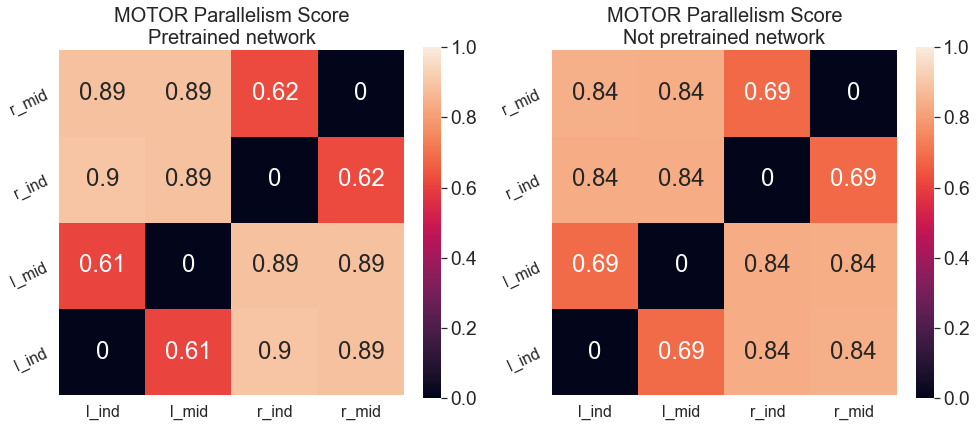

In [596]:
tools = reload(tools)

plt.figure(figsize=(14,7))
sns.set(font_scale=1.75)
plt.subplot(121)
mat = np.mean(ps_motor_pretraining,axis=2)
ax = sns.heatmap(mat,vmin=0,vmax=1,square=True,cbar=True,cbar_kws={'fraction':0.046},
                 annot=True,annot_kws={"size": 24})
ax.invert_yaxis()
plt.xticks(np.arange(0.5,len(classes_motor)+0.5),classes_motor,fontsize=16)
plt.yticks(np.arange(0.5,len(classes_motor)+0.5),classes_motor,fontsize=16,rotation=25)
plt.title("MOTOR Parallelism Score\nPretrained network",fontsize=20)

plt.subplot(122)
mat = np.mean(ps_motor_nopretraining,axis=2)
ax = sns.heatmap(mat,vmin=0,vmax=1,square=True,cbar=True,cbar_kws={'fraction':0.046},
                 annot=True,annot_kws={"size": 24})
ax.invert_yaxis()
plt.xticks(np.arange(0.5,len(classes_motor)+0.5),classes_motor,fontsize=16)
plt.yticks(np.arange(0.5,len(classes_motor)+0.5),classes_motor,fontsize=16,rotation=25)
plt.title("MOTOR Parallelism Score\nNot pretrained network",fontsize=20)
plt.tight_layout()